**We now implement Grover's algorithm for the above case of 2 qubits for |w⟩ = |11>**

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

We start by preparing a quantum circuit with two qubits:

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

First, we need to initialize the state |s⟩. Let's create a general function (for any number of qubits) so we can use it again later:

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

Apply the Oracle for |w> = |11>. This oracle is specific to 2 qubits:

In [5]:
grover_circuit.barrier()
grover_circuit.cz(0,1) # Oracle
grover_circuit.barrier()
grover_circuit.draw()

┌───┐ ░     ░ 
q_0: ┤ H ├─░──■──░─
     ├───┤ ░  │  ░ 
q_1: ┤ H ├─░──■──░─
     └───┘ ░     ░

We now want to apply the diffuser (Us). As with the circuit that initializes |s⟩, we'll create a general diffuser (for any number of qubits) so we can use it later in other problems.

In [6]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.barrier()
grover_circuit.draw()

┌───┐ ░     ░ ┌───┐┌───┐   ┌───┐ ░ 
q_0: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├─░─
     ├───┤ ░  │  ░ ├───┤├───┤ │ ├───┤ ░ 
q_1: ┤ H ├─░──■──░─┤ H ├┤ Z ├─■─┤ H ├─░─
     └───┘ ░     ░ └───┘└───┘   └───┘ ░

**Result(Simulator)**

In [7]:
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

As expected the amplitude of every state that is not |11> is 0, this means we have a 100% chance of measuring |11>.

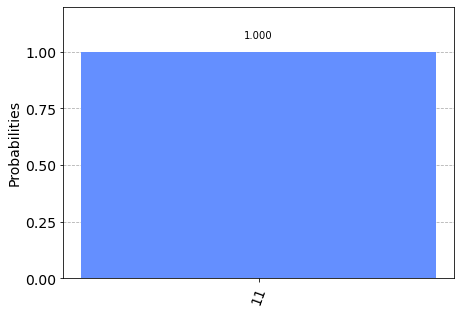

In [8]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

**Result(Real Device)**

In [9]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_belem


In [10]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


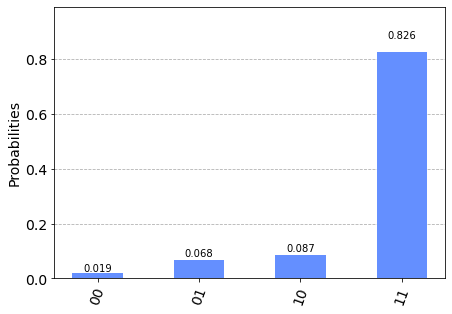

In [11]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)